# Final Project

Korey Ray

### About this template

This file is a **template** for filling out and submitting your final project. As such, I've created sub-sections along the lines of what we'd like to see. Your job is to **fill out** these sections, using the dataset and research question of your choice.

### Things to be aware of

- Your project likely depends on **data**. Make sure any dataset you will analyze is *stored in your DataHub directory*, so you can submit it along with your project.  
- Each of these sections will be assigned a point score. Make sure you add code cells in the relevant section, as needed.
- The final project should be completed independently.

## Introduction (2 pts.)

<!-- Questions to answer:

1. What dataset are you looking at? 
2. Where/how was it created? 
3. What research question(s) will you be asking? 

These should be answered in Markdown. -->

### Dataset #1
- Dataset Name: Downtown San Diego Unsheltered Count
- Link to the dataset: [downtownsandiego.org](https://downtownsandiego.org/clean-and-safe/unhoused-care/) [(pdf)](https://downtownsandiego.org/wp-content/uploads/2024/03/February-2024-Unsheltered-Count-w-Maps.pdf)
- Number of observations: 146 (12 months * 12 years + 2 months)
- Number of variables: 2 (date, count)

This dataset contains monthly counts of unsheltered people performed by the Downtown San Diego Partnership using the Clean & Safe Program methodology. The `.pdf` was converted to `.csv` by hand.

### Dataset #2
- Dataset Name: Downtown San Diego Precipitation
- Link to the dataset: generated from [scacis.rcc-acis.org](https://scacis.rcc-acis.org/)
- Number of observations: 146 (12 months * 12 years + 2 months)
- Number of variables: 2 (date, precipitation)

This dataset contains the monthly sum of precipitation (in inches of water) January 2012 to March 2024, measured at the San Diego International Airport weather station. This acts as a proxy for the precipitation experienced across the rest of Downtown San Diego.

### Research Question
How closely has the unsheltered homeless count correlated to precipitation?

## Data (3 pts.)

This section should contain **descriptive statistics** about your data. This includes (but is not limited to):

1. Overall `shape` of the data. 
2. Summary statistics, e.g., central tendency, variability, of key **features** (i.e., columns).
3. Histograms / count-plots of key features (i.e., columns). 
4. Information about missing values, if relevant.  
5. Information about **merging** datasets, if relevant.

These should be **answered** using Python code (but can be written in Markdown if you prefer).

### Set Up

#### Imports & Helpers

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# data
def fetchMeltMerge(csv, id, var, value, data):
  newData = pd.read_csv(csv, skipinitialspace=True)
  newMelt = pd.melt(newData, id_vars=[id], var_name=var, value_name=value)
  
  if data.empty:
    return newMelt
  else:
    return pd.merge(data, newMelt, on=[id, var], how='outer')
  
# visualization
plt.rcParams['figure.figsize'] = (16, 8)
uhc = "Unsheltered Homeless Count"

def noLabels():
  plt.xlabel(" ")
  plt.ylabel(" ")


#### Wrangling

In [46]:
# dataName, dataLocation
dataFiles = [
  ('uhc', 'adata/dt_sd_unsheltered_count.csv'),
  ('precip', 'adata/sd_precip_92101.csv')
]

# create an empty frame to populate
df = pd.DataFrame()

# pull in all the data
for dataName, dataLocation in dataFiles:
  df = fetchMeltMerge(dataLocation, 'Year', 'Month', dataName, df)

# do some cleaning up
monthToNumber = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df['Month'].replace(monthToNumber, inplace=True)
df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)
df.rename(columns={'Month':'month', 'Year':'year'}, inplace=True)

### Exploratory Data Analysis

In [47]:
df.head()

,year,month,uhc,precip
0,2012,1,486.0,0.40
1,2012,2,485.0,1.19
2,2012,3,405.0,0.97
3,2012,4,453.0,0.88
4,2012,5,513.0,0.02


In [48]:
df.iloc[:,2:].describe()[1:]

,uhc,precip
mean,912.294521,0.790616
std,364.987825,1.168362
min,405.000000,0.000000
25%,634.500000,0.010000
50%,801.500000,0.255000
75%,1128.500000,1.007500
max,2104.000000,5.140000


An initial key takeaway is the wide range for both variables, namely the gap between `min` and `max` in light of the mean for both. 

- The disparity in `uhc` is confounded by the dramatic increase in homelessness following COVID. 
- Precipitation's variation is driven by how frequently San Diego goes without rain paired with infrequent tropical storms.

## Visualizations (4 pts.)

This section should contain:

- **2-3 graphs** showing specific patterns or features you'd like to highlight. 
- Each visualization should be accompanied by a **short (1-2 sentences) description** of what you think it shows.

These should be **produced** using Python code (but the descriptions can be written in Markdown if you prefer).

One of my insights from the prior work was that using rolling values for both was important to finding the connection. A rolling value for `precip` makes sense because a continuous rainy period is more likely to lead an unsheltered person acquire/use a structure such as a tent. That would in turn drive up `uhc`, as the Clean & Safe Program treats structures like tents as 2 people. Similarly, a rolling value for `uhc` reduces noise inherent to the imperfect counting system.

For `uhc`, I'll use a mean with a 3 month window.  
For `precip`, the same window, but a sum.   

In [49]:
df['roll3precip'] = df['precip'].rolling(3, min_periods=3).sum()

df['roll3uhc'] = df['uhc'].rolling(3, min_periods=3, center=False).mean()

# Using a rolling window will create `NaN` values for the first 2 periods, so
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [50]:
df.head()

,year,month,uhc,precip,roll3precip,roll3uhc
0,2012,3,405.0,0.97,2.56,458.666667
1,2012,4,453.0,0.88,3.04,447.666667
2,2012,5,513.0,0.02,1.87,457.000000
3,2012,6,502.0,0.01,0.91,489.333333
4,2012,7,672.0,0.01,0.04,562.333333


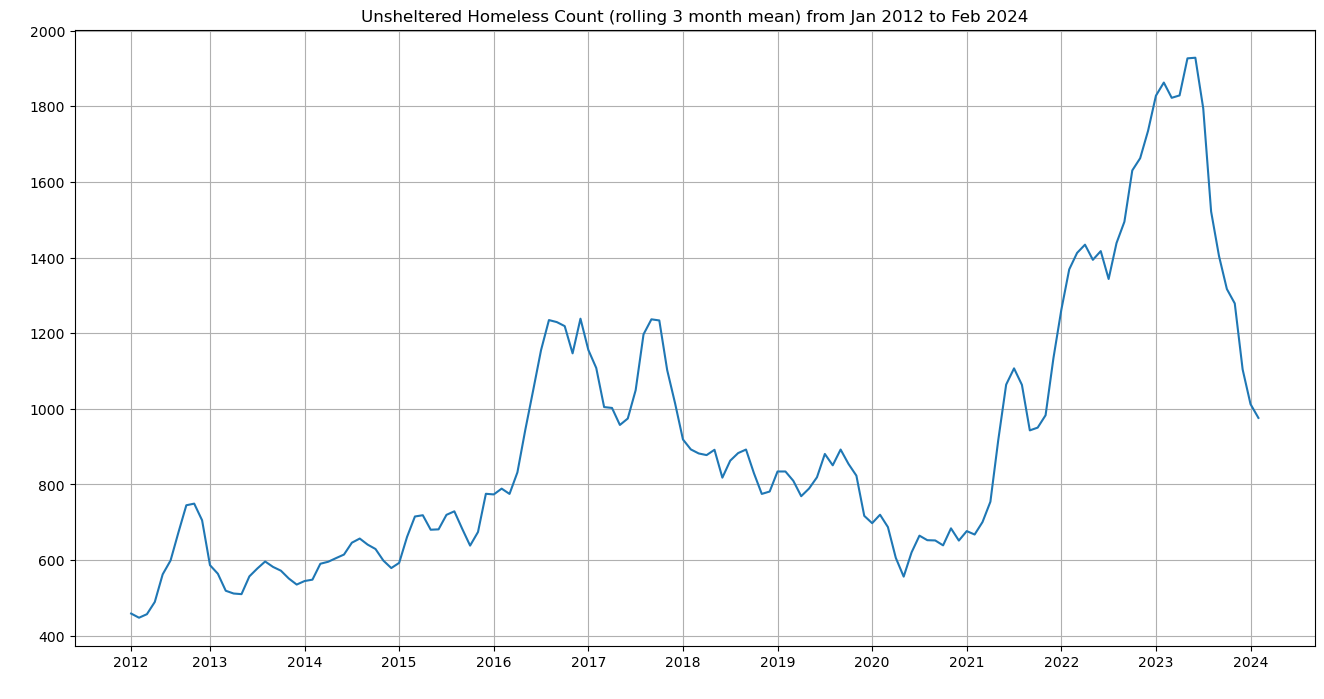

In [51]:
yearChangeIndices = df['year'].diff().ne(0).to_numpy().nonzero()[0]
plt.xticks(ticks=yearChangeIndices, labels=df.loc[yearChangeIndices, 'year'])
plt.title(f"{uhc} (rolling 3 month mean) from Mar 2012 to Feb 2024")
noLabels()
plt.grid()

sns.lineplot(data=df, x=df.index, y="roll3uhc")
plt.show()

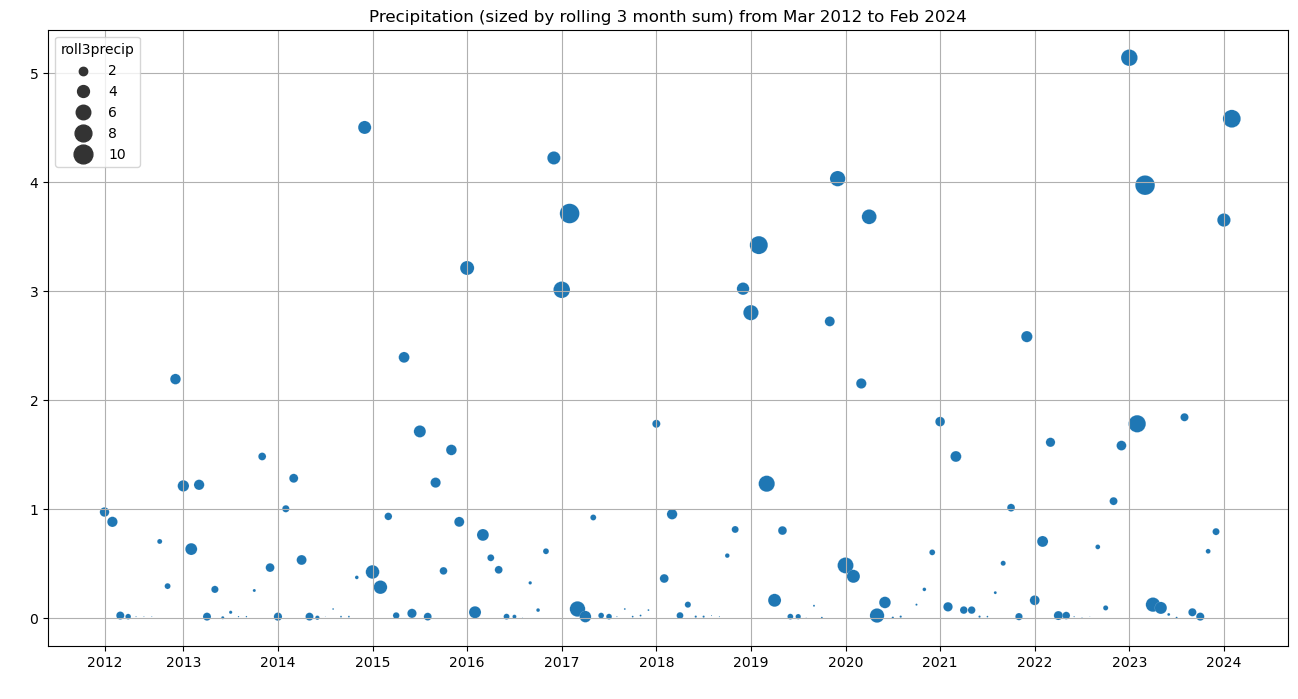

In [55]:
plt.xticks(ticks=yearChangeIndices, labels=df.loc[yearChangeIndices, 'year'])
plt.title(f"Precipitation (sized by rolling 3 month sum) from Mar 2012 to Feb 2024")
plt.grid()
noLabels()

sns.scatterplot(data=df, x=df.index, y="precip", size="roll3precip", sizes=(0, 200))
plt.show()

The largest peaks in the rolling unsheltered count appear to correspond with high periods of precipitation.

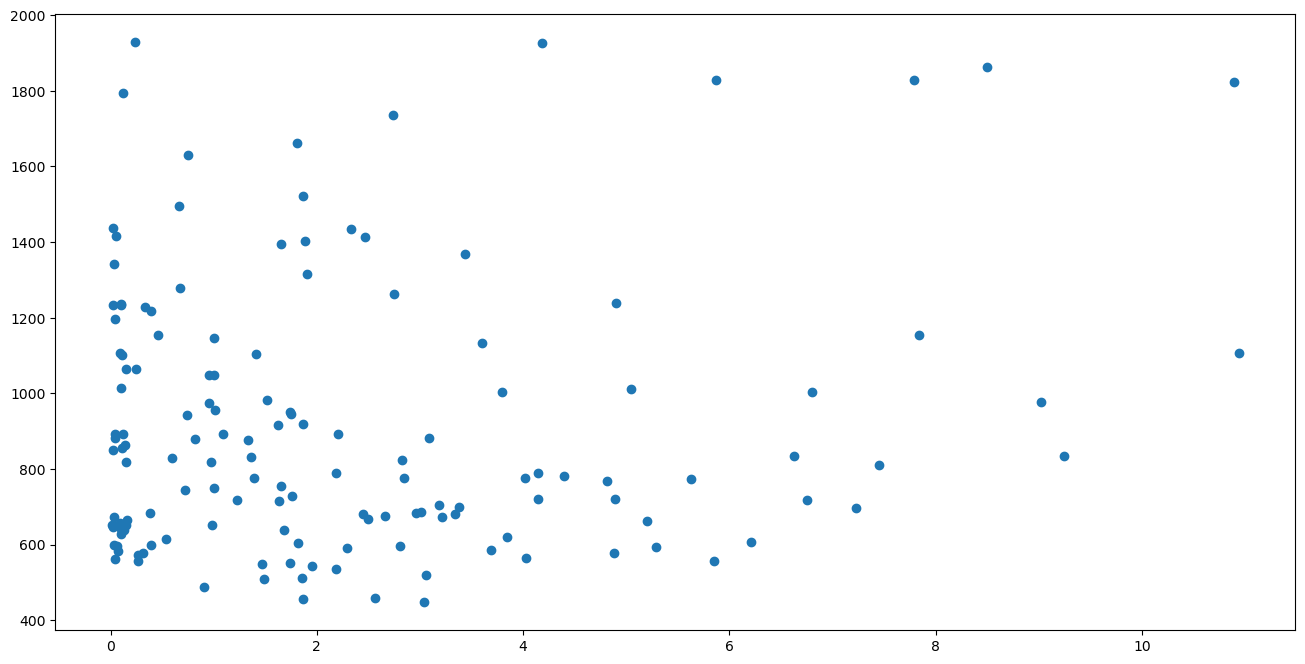

In [85]:
plt.scatter(data=df, y='roll3uhc', x="roll3precip")

## Analyses (4 pts.)

This section should contain:

- **2-3 analyses** using methods discussed in class (e.g., linear regression, logistic regression, etc.) to address your question.
- Each analysis should be accompanied by a short (1-3 sentences) **interpretation**. 
- Should also include **evaluation** of your model somehow, e.g., $R^2$, AIC, etc. 

These should be **produced** using Python code (but the interpretations can be written in Markdown if you prefer).

In [60]:
import statsmodels.formula.api as smf

model = lambda f: smf.ols(data=df, formula=f).fit()

In [78]:
formulas = [
    "uhc ~ precip",
    "uhc ~ roll3precip",
    "uhc ~ roll3precip + precip",
    "roll3uhc ~ precip",
    "roll3uhc ~ roll3precip",
    "roll3uhc ~ roll3precip + precip"
]

In [79]:
allModels = [model(f) for f in formulas]

In [81]:
allModelAIC = [m.aic for m in allModels]
allModelAIC

[2109.502373484709,
 2108.230544539603,
 2110.123113610808,
 2101.422020918109,
 2100.8907176185085,
 2102.822217925491]

## Limitations and Ethical Issues (3 pts.)

This section should contain a discussion of any **limitations** to your analysis, as well as any **ethical issues**, if relevant.

- Limitations could range from issues in the data (e.g., poor generalizability, biased sample) to the assumptions of the analysis (e.g., homoscedasticity vs. heteroscedasticity), and so on.
- Ethical issues should focus on concepts covered in class, e.g., relating to bias and/or privacy.  

These should be answered in Markdown.

YOUR ANSWER HERE

## Conclusion (1 pt.)

Draw a conclusion about the dataset and the questions you posed.

These should be answered in Markdown.

YOUR ANSWER HERE